In [1]:
import pylab as pl
import seaborn as sns

from qufit import *

---
Read the data and model specs from a config file:

In [2]:
cfg_file = 'configs/xmmlss12.cfg'

Initialise the fitting class and run the fit. This config file specifies 3 fits (ML, MCMC, Nested) using a simple faraday thin (SFT) model:

In [3]:
qufit = QUfit(cfg_file)
qufit.run_file()

------
Fitting ID2096
Model SFT
------
------
Initialisation:
P0 = 23.400
phi0 = 15.800
chi0 = 0.000
------
------
ML estimates:
P0 = 23.544
phi0 = 15.767
chi0 = -0.223
------


100%|████████████████████████████████████| 10000/10000 [00:12<00:00, 832.57it/s]


------
MCMC estimates:
P0 = 23.548 (-0.224, +0.223)
phi0 = 15.773 (-0.252, +0.248)
chi0 = -0.224 (-0.020, +0.021)
------


20058it [00:22, 896.16it/s, batch: 7 | bound: 5 | nc: 1 | ncall: 69611 | eff(%): 28.781 | loglstar: -133.167 < -128.174 < -128.741 | logz: -147.041 +/-  0.118 | stop:  0.938]           


------
Nested Sampler estimates:
P0 = 23.543 (-0.221, +0.225)
phi0 = 15.766 (-0.243, +0.246)
chi0 = -0.223 (-0.020, +0.020)
 
log Z = -147.040 +/- 0.108
------


13029it [00:09, 1362.22it/s, batch: 7 | bound: 7 | nc: 1 | ncall: 35195 | eff(%): 36.975 | loglstar: -134.714 < -128.168 < -128.514 | logz: -132.194 +/-  0.049 | stop:  0.957]      


 
log Z (3 sigma) = -132.197 +/- 0.044
------


14684it [00:10, 1371.33it/s, batch: 7 | bound: 7 | nc: 1 | ncall: 37999 | eff(%): 38.590 | loglstar: -133.672 < -128.169 < -128.535 | logz: -135.770 +/-  0.073 | stop:  0.935]      


 
log Z (10 sigma) = -135.782 +/- 0.065
------


Plot model fits onto data:

In [4]:
data = qufit.data
q_ml, u_ml = qufit.model.model(qufit.parms_ml, data.l2)
q_exp, u_exp = qufit.model.model(qufit.parms_mcmc[:,0], data.l2)

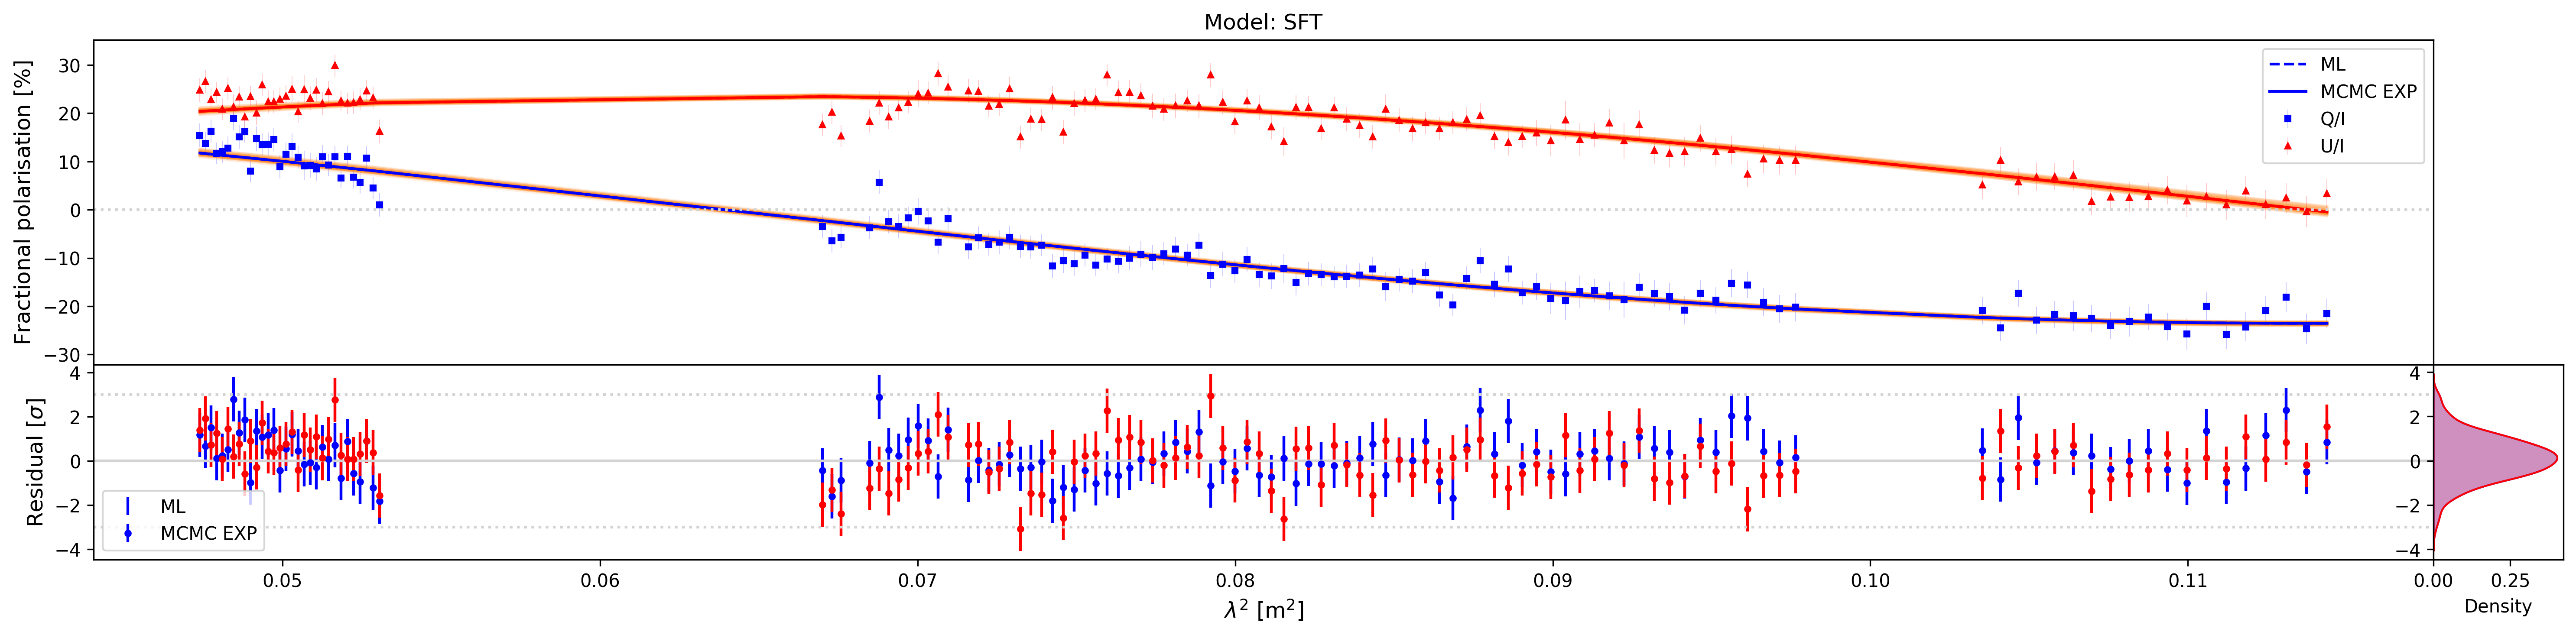

In [ ]:
fig = pl.figure()

# ----------
# Q,U

ax1 = fig.add_axes([0.1, 0.4, 0.9, 0.5])

if not qufit.cfg.pol_frac:
    ax1.errorbar(data.l2[::-1],data.stokesQn[::-1], yerr=data.noise, fmt='s', ms=3, c='blue', capthick=0, lw=0.1, label='Q')
    ax1.errorbar(data.l2[::-1],data.stokesUn[::-1], yerr=data.noise, fmt='^', ms=3, c='red', capthick=0, lw=0.1, label='U')
else:
    ax1.errorbar(data.l2[::-1],data.stokesQn[::-1], yerr=data.noise, fmt='s', ms=3, c='blue', capthick=0, lw=0.1, label='Q/I')
    ax1.errorbar(data.l2[::-1],data.stokesUn[::-1], yerr=data.noise, fmt='^', ms=3, c='red', capthick=0, lw=0.1, label='U/I')

    
# 50 random samples from the posterior...   
color = "#ff7f0e"
samples = qufit.model.mcmc_samples
for s in samples[np.random.randint(len(samples), size=50)]:
    mu_q, mu_u = qufit.model.model(s, data.l2)
    ax1.plot(data.l2[::-1],mu_q[::-1], c=color, alpha=0.1)
    ax1.plot(data.l2[::-1],mu_u[::-1], c=color, alpha=0.1)

ax1.plot(data.l2[::-1],q_ml[::-1], c='blue', ls='dashed', label='ML')
ax1.plot(data.l2[::-1],u_ml[::-1], c='red', ls='dashed')
ax1.plot(data.l2[::-1],q_exp[::-1], c='blue', label='MCMC EXP')
ax1.plot(data.l2[::-1],u_exp[::-1], c='red')

ax1.axhline(y=0, ls=':', c='lightgray')
if not qufit.cfg.pol_frac:
    ax1.set_ylabel(r"Intensity [$\mu$Jy/beam]", fontsize=12)
else:
    ax1.set_ylabel(r"Fractional polarisation [$\%$]", fontsize=12)
    
#ax1.set_xlabel(r"$\lambda^2$ [m$^2$]", fontsize=12)
ax1.legend()
ax1.set_title("Model: {}".format(qufit.cfg.modeltype))


# ----------
# Q,U residuals

ax2 = fig.add_axes([0.1, 0.1, 0.9, 0.3])

q_ml_res = (data.stokesQn - q_ml)/data.noise
u_ml_res = (data.stokesUn - u_ml)/data.noise

q_exp_res = (data.stokesQn - q_exp)/data.noise
u_exp_res = (data.stokesUn - u_exp)/data.noise

ax2.errorbar(data.l2[::-1], q_ml_res[::-1], yerr = np.ones_like(q_ml_res), c='blue', ls='', ms=3, label='ML')
ax2.errorbar(data.l2[::-1], u_ml_res[::-1], yerr = np.ones_like(u_ml_res), c='red', ls='', ms=3)
ax2.errorbar(data.l2[::-1], q_exp_res[::-1], yerr = np.ones_like(q_exp_res), c='blue', fmt='o', ls='', ms=3, label='MCMC EXP')
ax2.errorbar(data.l2[::-1], u_exp_res[::-1], yerr = np.ones_like(q_exp_res), c='red', fmt='o', ls='', ms=3)

ax2.axhline(y=0, ls='-', c='lightgray')
ax2.axhline(y=3, ls=':', c='lightgray')
ax2.axhline(y=-3, ls=':', c='lightgray')

if not qufit.cfg.pol_frac:
    ax2.set_ylabel(r"Intensity [$\mu$Jy/beam]", fontsize=12)
else:
    ax2.set_ylabel(r"Residual [$\sigma$]", fontsize=12)
    
ax2.set_xlabel(r"$\lambda^2$ [m$^2$]", fontsize=12)
ax2.legend()

# ----------
# Q,U residual histogram

ax3 = fig.add_axes([1.0, 0.1, 0.05, 0.3])
#ax3.hist(np.concatenate([q_ml_res,u_ml_res]), bins=10, orientation="horizontal", alpha=0.3)

sns.kdeplot(y=np.concatenate([q_ml_res,u_ml_res]), label = 'ML', fill=True, color='blue', ax=ax3)
sns.kdeplot(y=np.concatenate([q_exp_res,u_exp_res]), label = 'MCMC', fill=True, color='red', ax=ax3)

pl.show()